In [1]:
import os

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
import tensorflow as tf
import numpy as np
import pickle
import json
from sklearn.model_selection import train_test_split
import argparse
from tensorflow.contrib import layers
from tensorflow.contrib import rnn
from tensorflow.contrib import seq2seq
from seq2seq.rnn_seq2seq import DynamicSeq2Seq
from seq2seq.batch_utils import time_major_batch

In [4]:
with open("data/he_translate/en_words_enc.pkl", "rb") as fout:
    pph1_enc = pickle.load(fout)
with open("data/he_translate/he_words_enc.pkl", "rb") as fout:
    pph2_enc = pickle.load(fout)
with open("data/he_translate/vocab.txt") as fin:
    vocab = fin.readlines()
with open("data/he_translate/token2id.json") as fout:
    token2id = json.load(fout)
with open("data/he_translate/id2token.json") as fout:
    id2token = json.load(fout)
    id2token = {int(key):value for key, value in id2token.items()}

unk_id = 2
unk = " "
encode = lambda line: list(map(lambda t: token2id.get(t, unk_id), line))
decode = lambda line: "".join(list(map(lambda i: id2token.get(i, unk), line)))

indices = np.arange(len(pph1_enc))
train_ids, val_ids = train_test_split(indices, test_size=0.2, random_state=42)

train_input = [pph1_enc[i] for i in train_ids]
train_target = [pph2_enc[i] for i in train_ids]
train_data = list(zip(train_input, train_target))

val_input = [pph1_enc[i] for i in val_ids]
val_target = [pph2_enc[i] for i in val_ids]
val_data = list(zip(val_input, val_target))

vocab_size = len(vocab) + 3
emb_size = 64

encoder_args = {
    "cell": rnn.LSTMCell(256),
    "bidirectional": True,
}

decoder_args = {
    "cell": rnn.LSTMCell(512),
    "attention": True,
}

model = DynamicSeq2Seq(
    vocab_size, emb_size, encoder_args, decoder_args)

gpu_option = 0.25
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_option)

In [6]:
def inference(query):
    try:
        assert isinstance(query, str)
        query = encode(query)
    except:
        assert isinstance(query, list)
        assert isinstance(query[0], int)
    query_batch, query_batch_len = time_major_batch([query])
    predicted = sess.run(
        model.decoder.inference_prediction, 
        feed_dict={
            model.encoder.inputs: query_batch, 
            model.encoder.inputs_length: query_batch_len}).reshape(-1)
    predicted_line = decode(predicted)
    return predicted_line

In [7]:
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [8]:
saver = tf.train.Saver()

In [9]:
saver.restore(sess, "./logs_170424_he_en/model/10/model.cpkl")

In [10]:
for i in np.random.randint(len(val_data), size=10):
    query, target = val_data[i]
    try:
        print("\n".join((decode(query), inference(query), decode(target))))
    except:
        print("\n".join((query, inference(query))))
    print("-"*80)

eli
אלי 
אלי
--------------------------------------------------------------------------------
1959 Israeli legislative election
הבחירות לכנסת העשרי חשמה 
הבחירות לכנסת הרביעית
--------------------------------------------------------------------------------
2015 in the United States
קטגוריה:2015 בארצות הברית 
2015 בארצות הברית
--------------------------------------------------------------------------------
Spouses of politicians
קטגוריה:פוליטיקאים מדינים 
קטגוריה:בני זוג של פוליטיקאים
--------------------------------------------------------------------------------
1853 by country
קטגוריה:1853 לפי מד
קטגוריה:1853 לפי מדינות
--------------------------------------------------------------------------------
Location map Russia Sakhalin Oblast
תבנית:מפת מיקום/סחלין אובלסט 
תבנית:מפת מיקום/מחוז סחלין
--------------------------------------------------------------------------------
Chief of Staff of the United States Army
הארמייה הממלכתית של ארמייה המדינתית 
ראש מטה צבא ארצות הברית
-------------

In [11]:
for i in np.random.randint(len(val_data), size=10):
    target, query = val_data[i]
    try:
        print("\n".join((decode(query), inference(query), decode(target))))
    except:
        print("\n".join((query, inference(query))))
    print("-"*80)

קלגנפורט
Clagenfort 
Klagenfurt
--------------------------------------------------------------------------------
626
6266 
626
--------------------------------------------------------------------------------
R
RR 
R
--------------------------------------------------------------------------------
איבגי
ivgy 
ivgy
--------------------------------------------------------------------------------
הסימפוניה החמישית של צ'ייקובסקי
Symphony No. 1 
Symphony No. 5
--------------------------------------------------------------------------------
ניקופול
Nikopoll 
Nikopol
--------------------------------------------------------------------------------
משפטים
Mishpatian
Statute
--------------------------------------------------------------------------------
תבנית:מפת מיקום/הוואי
Location map India Hawaii
Location map USA Hawaii
--------------------------------------------------------------------------------
קטגוריה:ניו יורק: ישיבות
Populated places in New York
Orthodox yeshivas in New York City
-----

In [11]:
query = "Can I access my policy information online?"
print(inference(query))

How can I apply police on my interviews?  


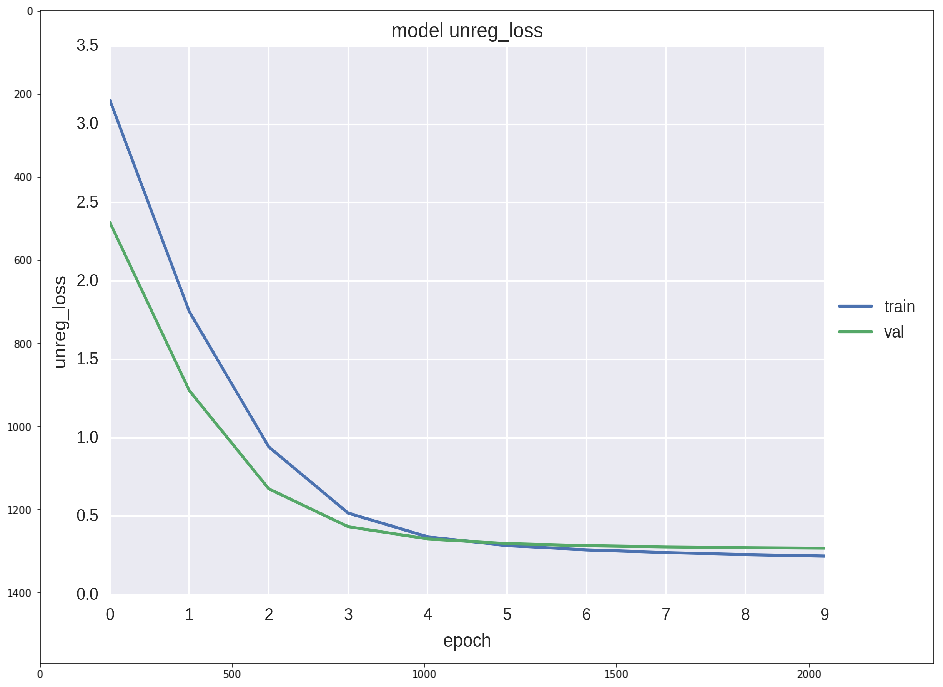

In [12]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from PIL import Image

%matplotlib inline
pil_im = Image.open("./logs_170424_he_en/model/10/plotter/unreg_loss.png", 'r')
figure(figsize = (16,12))
imshow(np.asarray(pil_im), interpolation='nearest', aspect='auto')